### Анализ собранных данных

In [1]:
import pandas as pd
import numpy as np
import re
import math
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_excel("data_with_sentiment.xlsx")

In [3]:
df.head()

Name       Date                                             Review  \
0  Лариса 2021-09-16  Главный минус - очень много мигрантов. С транс...   
1  Ульяна 2021-08-31  ЖК радует просторным пешеходным бульваром, где...   
2    Леша 2021-08-25  Касаемо самого комплекса — здесь есть нескольк...   
3   Алена 2021-02-17  Микрорайон представляет место с развитой инфра...   
4   Мария 2024-12-22  Квартиру приняли хоть и с замечаниями, но за т...   

   Rating Developer      Website  Sentiment  
0       5       ПИК  Novostroy-m         -1  
1       4       ПИК  Novostroy-m          1  
2       5       ПИК  Novostroy-m          1  
3       5       ПИК  Novostroy-m          1  
4       5       ПИК    Forum-zhk          1

In [4]:
df.shape[0]

3953

In [5]:
duplicates = df.duplicated(subset=['Review']).sum()
duplicates

0

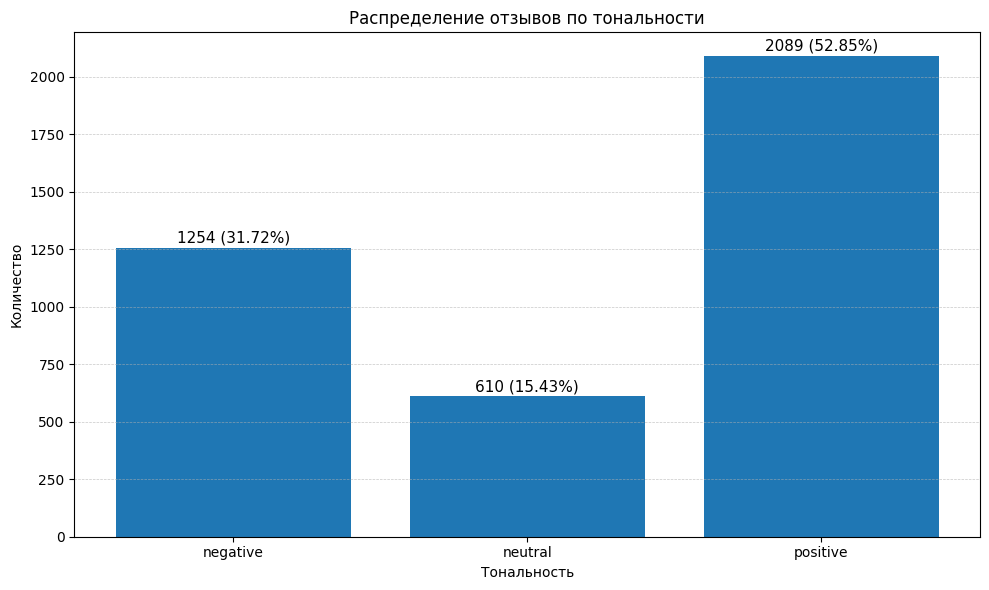

In [6]:
label_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}
df['sentiment_label'] = df['Sentiment'].map(label_map)

dist = (
    df['sentiment_label']
    .value_counts()
    .rename_axis('sentiment')
    .reset_index(name='count')
    .assign(percentage=lambda x: x['count'] / x['count'].sum() * 100)
    .sort_values('sentiment')
)

plt.figure(figsize=(10, 6))
bars = plt.bar(dist['sentiment'], dist['count'])

for bar, pct in zip(bars, dist['percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + max(dist['count']) * 0.005, 
             f"{height:.0f} ({pct:.2f}%)",
             ha='center', va='bottom', fontsize=11)

plt.title('Распределение отзывов по тональности')
plt.xlabel('Тональность')
plt.ylabel('Количество')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

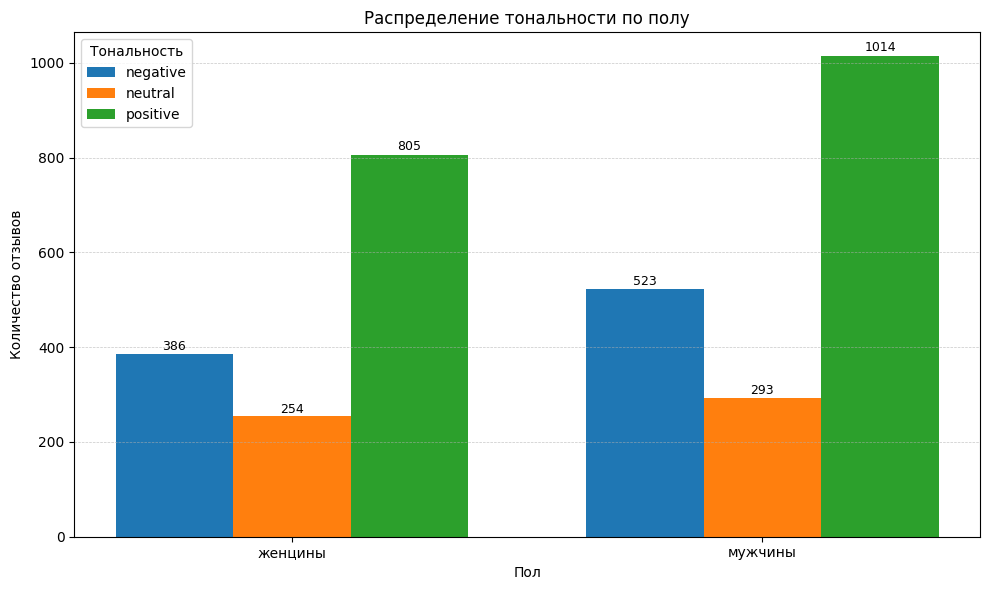

In [7]:
def guess_gender(name: str) -> str:
    if not isinstance(name, str):
        return 'unknown'
    name = name.strip()
    if len(name) < 3 or re.search(r'\d', name) or re.search(r'[^A-Za-zА-Яа-яЁё\- ]', name):
        return 'unknown'
    token = name.split()[0].split('-')[0].lower()
    last = token[-1]
    male_exceptions = {'никита', 'илья', 'андреа'}
    if token in male_exceptions:
        return 'мужчины'
    return 'женцины' if last in {'а', 'я', 'e'} else 'мужчины'

df['gender'] = df['Name'].apply(guess_gender)

gender_sent = (
    df[df['gender'] != 'unknown']
    .groupby(['gender', 'sentiment_label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

plt.figure(figsize=(10, 6)) 
genders = gender_sent['gender']
sentiments = ['negative', 'neutral', 'positive']
x = np.arange(len(genders))
width = 0.25
for i, s in enumerate(sentiments):
    counts = gender_sent[s]
    bars = plt.bar(x + (i - 1) * width, counts, width, label=s)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2,
                 height + max(counts) * 0.005,
                 f"{int(height)}",
                 ha='center', va='bottom', fontsize=9)
plt.xticks(x, genders)
plt.xlabel('Пол')
plt.ylabel('Количество отзывов')
plt.title('Распределение тональности по полу')
plt.legend(title='Тональность')
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

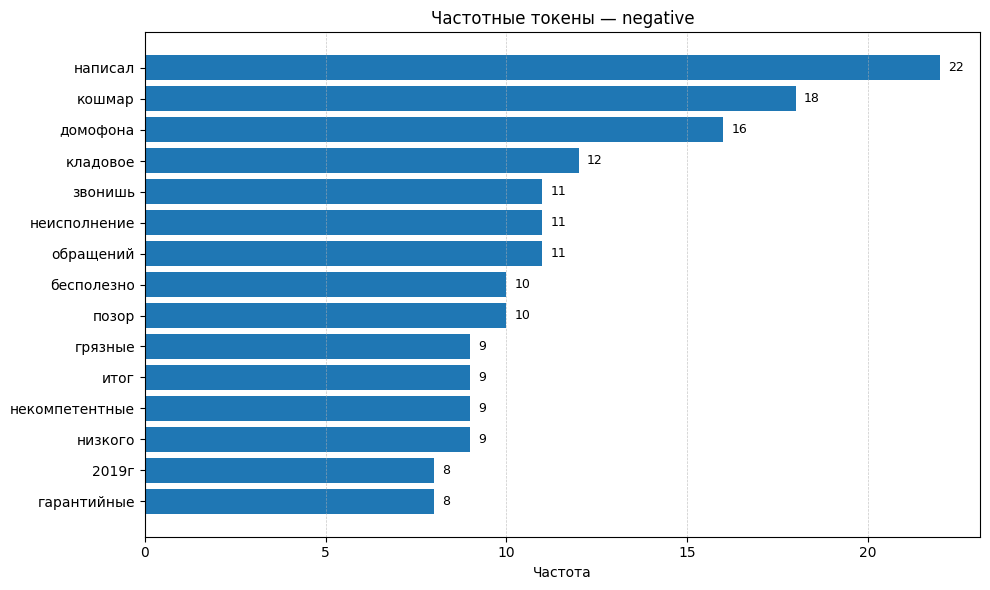

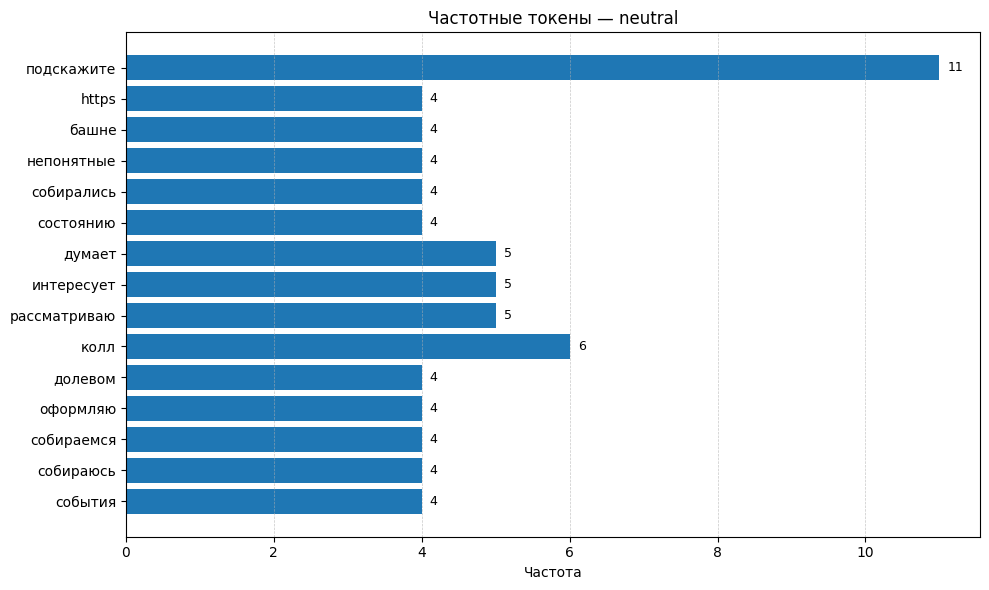

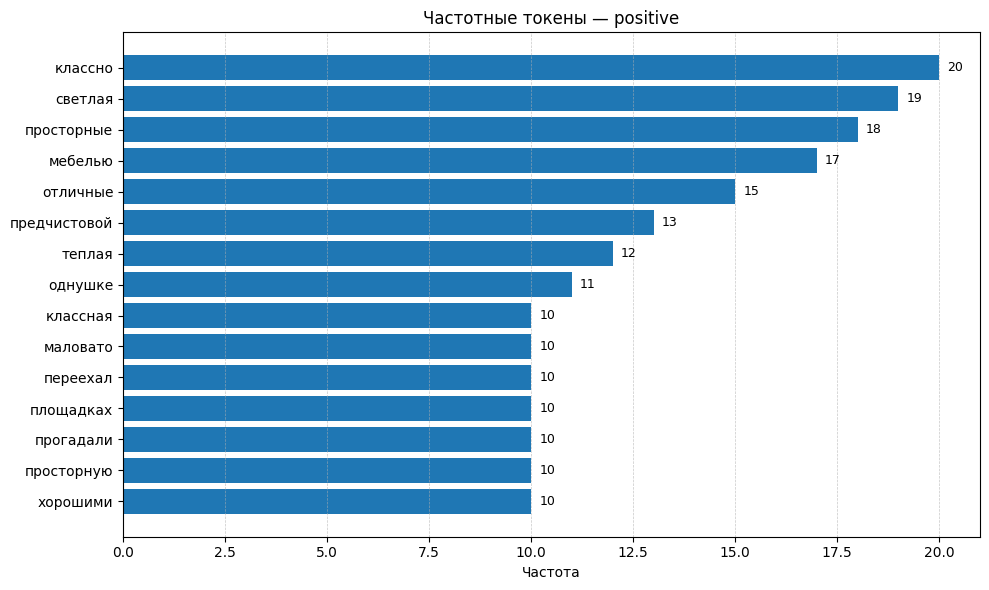

In [ ]:
russian_stop = set("""
и в во не что он на я с со как а то все она так его но да ты к у же вы за бы по ее мне было вот от меня еще нет о из ему теперь когда даже ну вдруг ли если уже или ни быть был него до вас нибудь опять уж вам ведь там потом себя ничего ей может они тут где есть надо ней для мы тебя их чем была сам чтоб без будто чего раз тоже себе под будет ж туда откуда кто именно вдруг когда-нибудь
""".split())
vectorizer = CountVectorizer(
    stop_words=list(russian_stop) + ['the', 'and', 'for', 'with', 'that', 'this', 'have', 'has', 'was', 'are', 'but', 'not'],
    min_df=5,
    ngram_range=(1, 1),
    lowercase=True
)
X = vectorizer.fit_transform(df['Review'].astype(str))
feature_names = np.array(vectorizer.get_feature_names_out())

token_counts = defaultdict(Counter)
total_counts = Counter()
for row_vec, lbl in zip(X, df['Sentiment']):
    row_arr = np.asarray(row_vec.todense()).ravel()
    idxs = np.where(row_arr > 0)[0]
    for idx in idxs:
        tok = feature_names[idx]
        cnt = row_arr[idx]
        token_counts[lbl][tok] += cnt
        total_counts[tok] += cnt

def log_odds(token: str, class_id: int, alpha: float = 0.01) -> float:
    A = token_counts[class_id][token] + alpha
    B = sum(token_counts[class_id].values()) + alpha * len(feature_names)
    C = total_counts[token] - token_counts[class_id][token] + alpha
    D = (sum(total_counts.values()) -
         sum(token_counts[class_id].values()) + alpha * len(feature_names))
    return math.log((A / (B - A)) / (C / (D - C)))

for class_id, name in [(-1, 'negative'), (0, 'neutral'), (1, 'positive')]:
    scores = {tok: log_odds(tok, class_id) for tok in feature_names}
    top15 = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:15]
    df_top = pd.DataFrame(top15, columns=['token', 'score'])
    counts = [token_counts[class_id][t] for t in df_top['token']]

    fig, ax = plt.subplots(figsize=(10, 6))
    y_pos = np.arange(len(df_top))[::-1]
    bars = ax.barh(y_pos, counts)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_top['token'])

    max_cnt = max(counts)
    offset = max_cnt * 0.01
    for bar in bars:
        width_val = bar.get_width()
        ax.text(width_val + offset,
                bar.get_y() + bar.get_height() / 2,
                f"{int(width_val)}",
                va='center', ha='left', fontsize=9)

    ax.set_xlabel('Частота')
    ax.set_title(f'Частотные токены — {name}')
    ax.grid(axis='x', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

Корреляция между длиной отзыва и Sentiment: -0.147


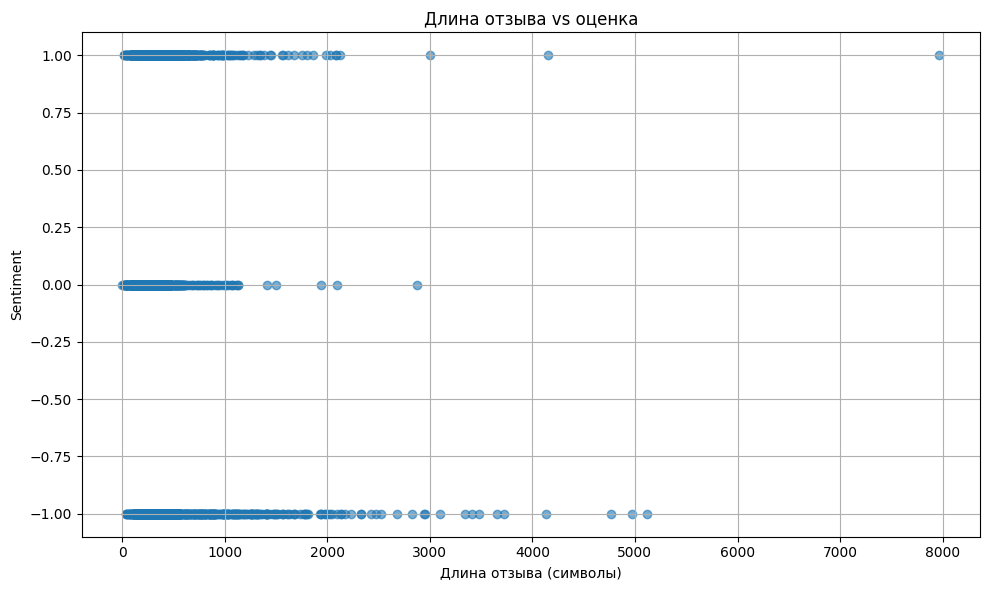

In [ ]:
text_col = 'Review'
sentiment_col = 'Sentiment' 

df['review_length'] = df[text_col].str.len()

corr = df['review_length'].corr(df[sentiment_col])
print(f"Корреляция между длиной отзыва и {sentiment_col}: {corr:.3f}")

plt.figure(figsize=(10, 6))
plt.scatter(df['review_length'], df[sentiment_col], alpha=0.6)
plt.xlabel('Длина отзыва (символы)')
plt.ylabel(sentiment_col)
plt.title('Длина отзыва vs оценка')
plt.grid(True)
plt.tight_layout()
plt.show()

### Перемешивание данных

In [ ]:
src_file = 'data_with_sentiment.xlsx' 
out20_file = 'data_with_sentiment_test.xlsx' 
out80_file = 'data_with_sentiment_new.xlsx'

df = pd.read_excel(src_file)
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

split_idx = int(len(df_shuffled) * 0.20)
df20 = df_shuffled.iloc[:split_idx]
df80 = df_shuffled.iloc[split_idx:]

df20.to_excel(out20_file, index=False)
df80.to_excel(out80_file, index=False)

cnt20 = df20['Sentiment'].value_counts().sort_index()
cnt80 = df80['Sentiment'].value_counts().sort_index()

summary = pd.DataFrame({
    'Sentiment': cnt20.index,
    '20_count': cnt20.values,
    '80_count': cnt80.reindex(cnt20.index, fill_value=0).values}).sort_values('Sentiment')

print("\nСводка по сентименту:")
print(summary.to_string(index=False))


Сводка по сентименту:
 Sentiment  20_count  80_count
        -1       259       995
         0       111       499
         1       420      1669


### Модели


--- Validation ---
              precision    recall  f1-score   support

         neg      0.741     0.871     0.801       249
         neu      0.481     0.312     0.379       125
         pos      0.827     0.827     0.827       417

    accuracy                          0.760       791
   macro avg      0.683     0.670     0.669       791
weighted avg      0.745     0.760     0.748       791


--- Test ---
              precision    recall  f1-score   support

         neg      0.750     0.822     0.785       259
         neu      0.453     0.306     0.366       111
         pos      0.819     0.840     0.830       420

    accuracy                          0.759       790
   macro avg      0.674     0.656     0.660       790
weighted avg      0.745     0.759     0.750       790



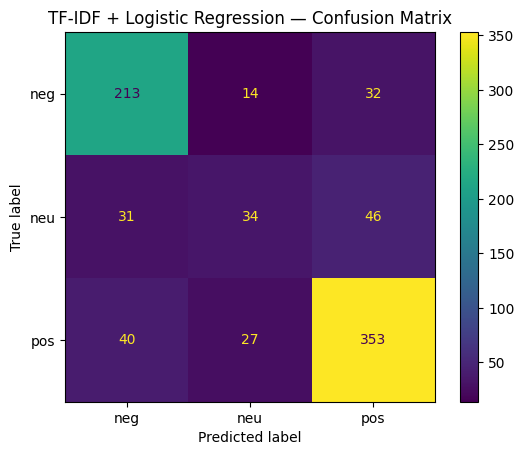

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

train_file = 'data_with_sentiment_new.xlsx' 
test_file = 'data_with_sentiment_test.xlsx' 

train_df = pd.read_excel(train_file)[['Review', 'Sentiment']].dropna()
test_df = pd.read_excel(test_file)[['Review', 'Sentiment']].dropna()

sent_map = {-1: 'neg', 0: 'neu', 1: 'pos'}
train_df['Sentiment'] = train_df['Sentiment'].map(sent_map)
test_df['Sentiment'] = test_df['Sentiment'].map(sent_map)

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Review'], train_df['Sentiment'],
    test_size=0.25, random_state=42, stratify=train_df['Sentiment']
)

pipe = make_pipeline(
    TfidfVectorizer(min_df=3, ngram_range=(1, 2), stop_words='english'),
    LogisticRegression(class_weight='balanced', max_iter=400)
)

param_grid = {'logisticregression__C': [0.5, 1, 2, 4]}
grid = GridSearchCV(
    pipe, param_grid,
    scoring='f1_macro',
    cv=3,
    n_jobs=-1
)

grid.fit(X_train, y_train)

for name, X_split, y_split in [
        ('Validation', X_val, y_val),
        ('Test', test_df['Review'], test_df['Sentiment'])
]:
    y_pred = grid.predict(X_split)
    print(f'\n--- {name} ---')
    print(classification_report(y_split, y_pred, digits=3))

cm = confusion_matrix(
    test_df['Sentiment'],
    grid.predict(test_df['Review']),
    labels=['neg', 'neu', 'pos']
)
ConfusionMatrixDisplay(cm, display_labels=['neg', 'neu', 'pos']).plot(cmap='viridis')
plt.title('TF-IDF + Logistic Regression — Confusion Matrix')
plt.show()

Embedding: 100%|██████████| 790/790 [00:00<00:00, 1131.85it/s]



--- Validation ---
              precision    recall  f1-score   support

         neg      0.657     0.763     0.706       249
         neu      0.227     0.280     0.251       125
         pos      0.784     0.655     0.714       417

    accuracy                          0.630       791
   macro avg      0.556     0.566     0.557       791
weighted avg      0.656     0.630     0.638       791


--- Test ---
              precision    recall  f1-score   support

         neg      0.691     0.776     0.731       259
         neu      0.232     0.324     0.271       111
         pos      0.817     0.669     0.736       420

    accuracy                          0.656       790
   macro avg      0.580     0.590     0.579       790
weighted avg      0.693     0.656     0.669       790



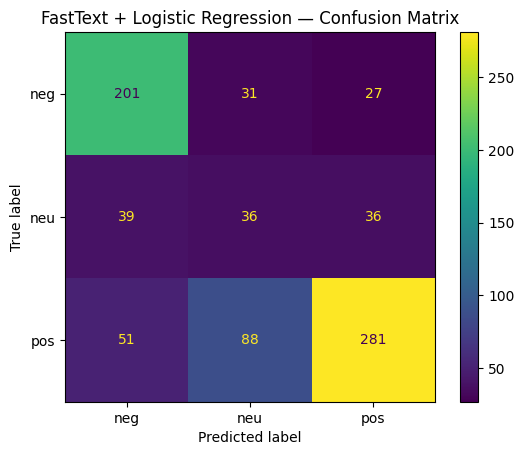

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from gensim.models.fasttext import load_facebook_vectors

train_file = 'data_with_sentiment_new.xlsx'
test_file = 'data_with_sentiment_test.xlsx'

train_df = pd.read_excel(train_file)[['Review', 'Sentiment']].dropna()
test_df = pd.read_excel(test_file)[['Review', 'Sentiment']].dropna()

sent_map = {-1: 'neg', 0: 'neu', 1: 'pos'}
train_df['Sentiment'] = train_df['Sentiment'].map(sent_map)
test_df['Sentiment'] = test_df['Sentiment'].map(sent_map)

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Review'], train_df['Sentiment'],
    test_size=0.25, random_state=42, stratify=train_df['Sentiment']
)

ft = load_facebook_vectors('cc.ru.300.bin')

def ft_mean(text: str) -> np.ndarray:
    """Средний вектор токенов (игнорируем не-слова)."""
    tokens = [tok for tok in text.lower().split() if tok.isalpha()]
    if not tokens:
        return np.zeros(ft.vector_size)
    return np.mean([ft[token] for token in tokens], axis=0)

def embed_series(series):
    return np.vstack([ft_mean(t) for t in tqdm(series, desc='Embedding')])

X_tr_ft = embed_series(X_train)
X_val_ft = embed_series(X_val)
X_te_ft = embed_series(test_df['Review'])

lr = LogisticRegression(class_weight='balanced', C=2, max_iter=400)
lr.fit(X_tr_ft, y_train)

for name, X_, y_ in [
        ('Validation', X_val_ft, y_val),
        ('Test', X_te_ft, test_df['Sentiment'])
]:
    preds = lr.predict(X_)
    print(f'\n--- {name} ---')
    print(classification_report(y_, preds, digits=3))

cm = confusion_matrix(
    test_df['Sentiment'],
    lr.predict(X_te_ft),
    labels=['neg', 'neu', 'pos']
)
ConfusionMatrixDisplay(cm, display_labels=['neg', 'neu', 'pos']).plot(cmap='viridis')
plt.title('FastText + Logistic Regression — Confusion Matrix')
plt.show()

/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 

{'eval_f1_macro': 0.6461644208224531, 'eval_loss': 0.7761880159378052, 'eval_runtime': 50.3157, 'eval_samples_per_second': 15.721, 'eval_steps_per_second': 1.968, 'epoch': 1.01}


 28%|██▊       | 500/1782 [23:59<51:28,  2.41s/it]  

{'loss': 0.8157, 'grad_norm': 5.206132888793945, 'learning_rate': 1.4388327721661056e-05, 'epoch': 1.68}


                                                    
 34%|███▎      | 600/1782 [30:04<1:06:02,  3.35s/it]

{'eval_f1_macro': 0.6465952156018504, 'eval_loss': 0.7724940180778503, 'eval_runtime': 84.6471, 'eval_samples_per_second': 9.345, 'eval_steps_per_second': 1.17, 'epoch': 2.02}


                                                    
 51%|█████     | 900/1782 [49:42<40:50,  2.78s/it]

{'eval_f1_macro': 0.6699381881169324, 'eval_loss': 1.0416688919067383, 'eval_runtime': 72.8366, 'eval_samples_per_second': 10.86, 'eval_steps_per_second': 1.359, 'epoch': 3.03}


 56%|█████▌    | 1000/1782 [56:36<48:29,  3.72s/it] 

{'loss': 0.5181, 'grad_norm': 10.678773880004883, 'learning_rate': 8.77665544332211e-06, 'epoch': 3.37}


                                                       
 67%|██████▋   | 1200/1782 [1:11:27<46:20,  4.78s/it]

{'eval_f1_macro': 0.6864086145398608, 'eval_loss': 1.3433582782745361, 'eval_runtime': 74.1658, 'eval_samples_per_second': 10.665, 'eval_steps_per_second': 1.335, 'epoch': 4.04}


 84%|████████▍ | 1500/1782 [1:33:16<20:54,  4.45s/it]  

{'loss': 0.2699, 'grad_norm': 20.288000106811523, 'learning_rate': 3.1649831649831652e-06, 'epoch': 5.05}


                                                     
 84%|████████▍ | 1500/1782 [1:34:38<20:54,  4.45s/it]

{'eval_f1_macro': 0.6745960330615789, 'eval_loss': 1.6758909225463867, 'eval_runtime': 82.6084, 'eval_samples_per_second': 9.575, 'eval_steps_per_second': 1.198, 'epoch': 5.05}


100%|██████████| 1782/1782 [1:53:22<00:00,  3.82s/it]  


{'train_runtime': 6802.4584, 'train_samples_per_second': 2.092, 'train_steps_per_second': 0.262, 'train_loss': 0.46864040344786295, 'epoch': 6.0}


100%|██████████| 99/99 [01:19<00:00,  1.25it/s]



--- Validation ---
              precision    recall  f1-score   support

          -1      0.765     0.876     0.816       249
           0      0.500     0.328     0.396       125
           1      0.840     0.854     0.847       417

    accuracy                          0.777       791
   macro avg      0.702     0.686     0.686       791
weighted avg      0.762     0.777     0.766       791



100%|██████████| 99/99 [01:22<00:00,  1.19it/s]



*** Test macro-F1: 0.695


100%|██████████| 99/99 [01:34<00:00,  1.05it/s]



--- Test ---
              precision    recall  f1-score   support

          -1      0.784     0.853     0.817       259
           0      0.487     0.351     0.408       111
           1      0.853     0.869     0.861       420

    accuracy                          0.791       790
   macro avg      0.708     0.691     0.695       790
weighted avg      0.779     0.791     0.783       790



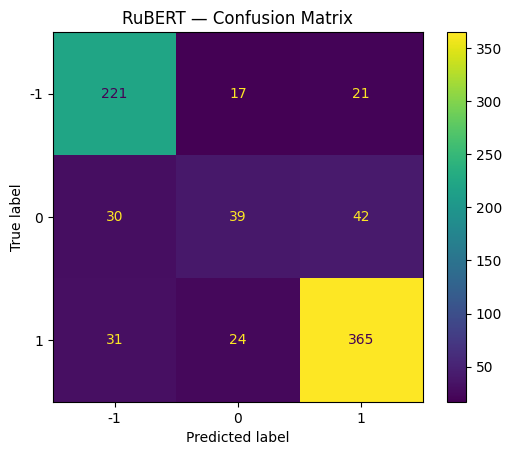

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

TRAIN_FILE = 'data_with_sentiment_new.xlsx'
TEST_FILE = 'data_with_sentiment_test.xlsx'

df_train = pd.read_excel(TRAIN_FILE)[['Review','Sentiment']].dropna()
df_test = pd.read_excel(TEST_FILE)[['Review','Sentiment']].dropna()

le = LabelEncoder().fit(df_train['Sentiment'])
df_train['label'] = le.transform(df_train['Sentiment'])
df_test ['label'] = le.transform(df_test ['Sentiment'])
target_names = [str(c) for c in le.classes_]

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    df_train['Review'], df_train['label'],
    test_size=0.25,
    stratify=df_train['label'],
    random_state=42
)

MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)

ds_tr = Dataset.from_dict({'text': X_tr.tolist(), 'labels': y_tr.tolist()}).map(tokenize, batched=True)
ds_val = Dataset.from_dict({'text': X_val.tolist(), 'labels': y_val.tolist()}).map(tokenize, batched=True)
ds_test= Dataset.from_dict({'text': df_test['Review'].tolist(), 'labels': df_test['label'].tolist()}).map(tokenize, batched=True)

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(df_train['label']),
    y=y_tr
)
class_w = torch.tensor(class_weights, dtype=torch.float)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(target_names))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs= model(**inputs)
        loss = torch.nn.functional.cross_entropy(
            outputs.logits,
            labels,
            weight=class_w.to(outputs.logits.device)
        )
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    preds  = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds, output_dict=True)
    return {"eval_f1_macro": report['macro avg']['f1-score']}

args = TrainingArguments(
    output_dir='bert_out',
    num_train_epochs=6,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy='steps',
    eval_steps=300,
    save_steps=300,
    load_best_model_at_end=True,
    metric_for_best_model='eval_f1_macro',
    greater_is_better=True,
    save_total_limit=2,
    report_to=None,
    no_cuda=True
)

trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=ds_tr,
    eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

val_out = trainer.predict(ds_val)
val_preds = val_out.predictions.argmax(-1)
val_labels= val_out.label_ids

print("\n--- Validation ---")
print(classification_report(
    val_labels,
    val_preds,
    target_names=target_names,
    digits=3
))

trainer.save_model('rubert_sentiment')
tokenizer.save_pretrained('rubert_sentiment')

metrics = trainer.evaluate(ds_test)
print(f"\n*** Test macro-F1: {metrics['eval_f1_macro']:.3f}")

test_preds = trainer.predict(ds_test).predictions.argmax(-1)
print("\n--- Test ---")
print(classification_report(
    df_test['label'],
    test_preds,
    target_names=target_names,
    digits=3
))

cm = confusion_matrix(df_test['label'], test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='viridis')
plt.title("RuBERT — Confusion Matrix")
plt.show()

### Интерпретация моделей и выделение ключевых признаков

In [4]:
import shap
import torch
import numpy as np
import pandas as pd
from transformers import TextClassificationPipeline
from shap.maskers import Text

TEST_FILE = 'data_with_sentiment_test.xlsx'
test_df = pd.read_excel(TEST_FILE)[['Review','Sentiment']].dropna()

device = 0 if torch.cuda.is_available() else -1
clf_pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device=device
)

def predict_prob(texts):
    if isinstance(texts, str):
        texts = [texts]
    prep = []
    for t in texts:
        if isinstance(t, (list, tuple, np.ndarray)):
            if any(isinstance(x, (list, tuple, np.ndarray)) for x in t):
                t = [elem for sub in t for elem in sub]
            prep.append(" ".join(map(str, t)))
        else:
            prep.append(str(t))
    preds = clf_pipe(prep)
    return np.array([[p["score"] for p in sample] for sample in preds], dtype=np.float32)

masker = Text(tokenizer)
label_names = ["neg", "neu", "pos"]  
explainer = shap.Explainer(
    predict_prob,
    masker,
    algorithm="partition",
    output_names=label_names
)

N = 3
sample_texts = test_df['Review'].sample(N, random_state=42).tolist()

shap_values = explainer(sample_texts)
shap.plots.text(shap_values)

/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
PartitionExplainer explainer: 4it [01:25, 28.55s/it]                       


In [5]:
samples = {
    'neg': "Ужасный дом, задержка на 9 месяцев",
    'neu': "Средний вариант, цены как у конкурентов",
    'pos': "Отличный район и комфортные планировки"
}

for lbl, txt in samples.items():
    vals = explainer([txt])
    print(f"\n--- {lbl.upper()} ---")
    shap.plots.text(vals[0])


--- NEG ---



--- NEU ---



--- POS ---


In [44]:
import numpy as np

classes = grid.best_estimator_.named_steps["logisticregression"].classes_
label_map = {label: idx for idx, label in enumerate(classes)}

vocab = grid.best_estimator_.named_steps["tfidfvectorizer"].get_feature_names_out()
coefs = grid.best_estimator_.named_steps["logisticregression"].coef_

def top_words(class_idx, n=10):
    idxs = np.argsort(coefs[class_idx])[-n:]
    return list(zip(vocab[idxs], coefs[class_idx][idxs]))

print("Positive words:", top_words(label_map['pos']))
print("Negative words:", top_words(label_map['neg']))

Positive words: [('сразу', 0.7770892975452014), ('комплекс', 0.7807283044324048), ('но', 0.7810342017138635), ('довольны', 0.781058213329594), ('понравилось', 0.7887569480092249), ('нравится', 0.8221597333631985), ('район', 0.8386675169086497), ('все', 0.9991871398810678), ('хорошо', 1.1437358330742455), ('хороший', 1.2376947027785237)]
Negative words: [('деньги', 0.7074866580726945), ('минусы', 0.7203244013414865), ('на', 0.8018818394356029), ('отношение', 0.829938902789615), ('месяцев', 0.834601455645039), ('месяца', 0.8460046759032888), ('обман', 0.8851914473046978), ('нет', 1.6205985485866947), ('не', 1.8179335030608534), ('пик', 1.9427046172520186)]


### Генерируем данные в Google Colab, файл - data_generation.ipynb, код также продублирован ниже

In [ ]:
# DATA_PATH = "data_with_sentiment_new.xlsx" 
# OUT_XLSX = "balanced_data_80_balanced.xlsx"
# MODEL_ID = "cointegrated/rut5-base-paraphraser"

# TEMPERATURE = 0.9
# J_LOWER, J_UPPER = 0.15, 0.85
# SLEEP_BETWEEN_GEN = 0.1

# from typing import Optional
# import re, time, random, pathlib, warnings
# import pandas as pd
# from tqdm.auto import tqdm
# import torch
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# warnings.filterwarnings("ignore", category=FutureWarning)

# if not pathlib.Path(DATA_PATH).exists():
#     raise FileNotFoundError(f"{DATA_PATH} not found")

# df = pd.read_excel(DATA_PATH)[["Review", "Sentiment"]].dropna()

# num2str = {1: "positive", -1: "negative", 0: "neutral"}
# if df["Sentiment"].dtype != object:
#     df["Sentiment"] = df["Sentiment"].map(num2str)

# print("Распределение классов до балансировки:\n",
#       df["Sentiment"].value_counts(), "\n")

# print("Загружаем RuT5-paraphraser …")
# dtype = torch.float16 if torch.cuda.is_available() else torch.float32
# tok = AutoTokenizer.from_pretrained(MODEL_ID, use_fast=False)
# model = AutoModelForSeq2SeqLM.from_pretrained(
#     MODEL_ID, torch_dtype=dtype, device_map="auto"
# )
# paraphraser = pipeline(
#     "text2text-generation",
#     model=model, tokenizer=tok,
#     max_length=128, num_beams=4, repetition_penalty=1.15,
# )

# def paraphrase(txt: str, T: float = TEMPERATURE) -> Optional[str]:
#     try:
#         out = paraphraser(
#             f"paraphrase: {txt}",
#             do_sample=True, top_k=50, top_p=0.95,
#             temperature=T, num_return_sequences=1
#         )[0]["generated_text"]
#         return out.strip(' \n"«»“”')
#     except Exception as e:
#         print("Paraphrase error:", e)
#         return None

# def clean(t: str) -> str:
#     return re.sub(r"\s+", " ", re.sub(r"<[^>]+>", " ", t)).strip()

# def jaccard(a: str, b: str) -> float:
#     sa, sb = set(a.lower().split()), set(b.lower().split())
#     return 1.0 if not (sa or sb) else len(sa & sb) / len(sa | sb)

# cnt = df["Sentiment"].value_counts()
# MAX_CLASS = cnt.max()
# MINORITY = [cls for cls, n in cnt.items() if n < MAX_CLASS]

# synth_rows = []
# for label in MINORITY:
#     need = MAX_CLASS - cnt[label]
#     pool = df[df["Sentiment"] == label]["Review"].tolist()
#     print(f"Генерируем для «{label}»: нужно {need}")
#     bar = tqdm(total=need, leave=False)
#     while need > 0:
#         src = clean(random.choice(pool))
#         new = paraphrase(src)
#         if not new:
#             continue
#         if not (J_LOWER < jaccard(src, clean(new)) < J_UPPER):
#             continue
#         if any(jaccard(clean(new), clean(r["Review"])) > J_UPPER
#                for r in synth_rows):
#             continue
#         synth_rows.append({"Review": new, "Sentiment": label})
#         need -= 1
#         bar.update(1)
#         time.sleep(SLEEP_BETWEEN_GEN)
#     bar.close()

# df_bal = pd.concat([df, pd.DataFrame(synth_rows)], ignore_index=True)
# df_bal = df_bal.sample(frac=1, random_state=42).reset_index(drop=True)

# df_bal.to_excel(OUT_XLSX, index=False)

# print("\nБаланс после генерации:")
# print(df_bal["Sentiment"].value_counts())
# print(f"Файл сохранён: {OUT_XLSX}")

### Смотрим новый датасет balanced_data_80_balanced

In [16]:
df_balanced = pd.read_excel("balanced_data_80_balanced.xlsx")

In [17]:
df_balanced.head()

Review Sentiment
0  Комментарий: Отдельный респект застройщику, чт...   neutral
1  Как это грустно не звучало. Ужасная организаци...  negative
2  В настоящее время цены на квартиры растут кажд...   neutral
3  Описание: Добрый день, Пик продает квартиры эк...  negative
4  Собираясь приобрести квартиру у данного застро...   neutral

In [18]:
duplicates_count = df_balanced.duplicated(subset=['Review']).sum()
duplicates_count

0

In [19]:
df_balanced.shape[0]

5007

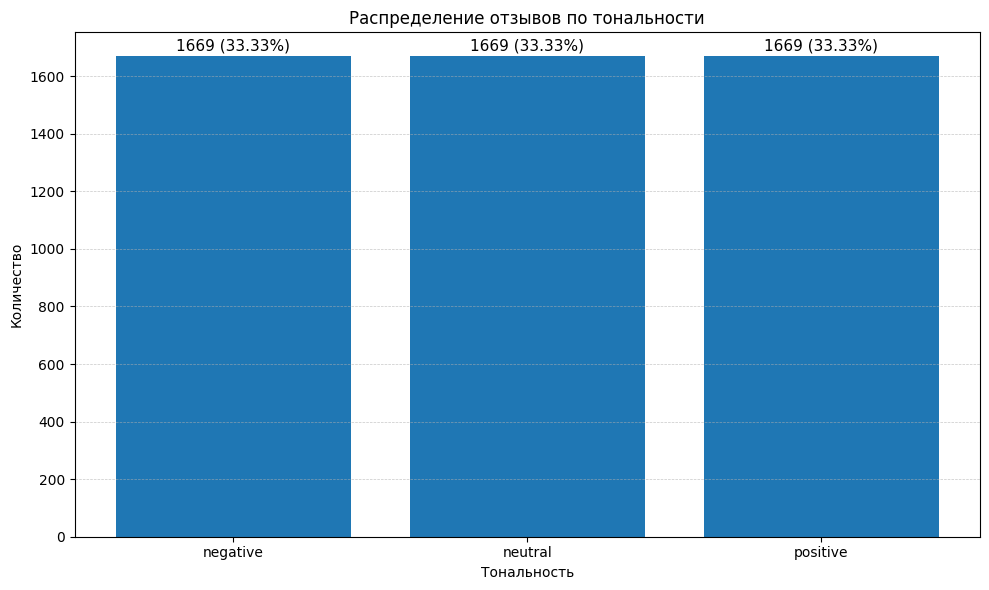

In [20]:
df_balanced['sentiment_label'] = df_balanced['Sentiment']

dist = (
    df_balanced['sentiment_label']
    .value_counts()
    .rename_axis('sentiment')
    .reset_index(name='count')
    .assign(percentage=lambda x: x['count'] / x['count'].sum() * 100)
    .sort_values('sentiment')
)

plt.figure(figsize=(10, 6))
bars = plt.bar(dist['sentiment'], dist['count'])

for bar, pct in zip(bars, dist['percentage']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             height + max(dist['count']) * 0.005, 
             f"{height:.0f} ({pct:.2f}%)",
             ha='center', va='bottom', fontsize=11)

plt.title('Распределение отзывов по тональности')
plt.xlabel('Тональность')
plt.ylabel('Количество')
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

### Модели на сбалансированных данных

Python(26198) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(26199) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Python(26200) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
huggingface/tokenizers: The current process just got forke


--- Validation ---
              precision    recall  f1-score   support

         neg      0.899     0.851     0.874       417
         neu      0.894     0.868     0.881       417
         pos      0.816     0.883     0.848       418

    accuracy                          0.867      1252
   macro avg      0.870     0.867     0.868      1252
weighted avg      0.870     0.867     0.868      1252


--- Test ---
              precision    recall  f1-score   support

         neg      0.771     0.807     0.789       259
         neu      0.467     0.252     0.327       111
         pos      0.800     0.874     0.835       420

    accuracy                          0.765       790
   macro avg      0.679     0.644     0.650       790
weighted avg      0.743     0.765     0.749       790



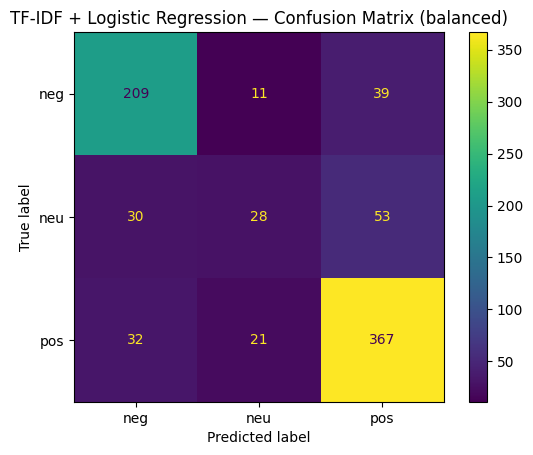

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

train_file = 'balanced_data_80_balanced.xlsx'
test_file = 'data_with_sentiment_test.xlsx'

train_df = pd.read_excel(train_file)[['Review', 'Sentiment']]
test_df = pd.read_excel(test_file )[['Review', 'Sentiment']]

label_map = {1:'pos', 0:'neu', -1:'neg',
    'positive':'pos','neutral':'neu','negative':'neg'
}
train_df['Sentiment'] = train_df['Sentiment'].map(label_map)
test_df ['Sentiment'] = test_df ['Sentiment'].map(label_map)

train_df = train_df.dropna(subset=['Sentiment'])
test_df = test_df .dropna(subset=['Sentiment'])

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Review'], train_df['Sentiment'],
    test_size=0.25, random_state=42, stratify=train_df['Sentiment']
)

pipe = make_pipeline(
    TfidfVectorizer(min_df=3, ngram_range=(1, 2), stop_words='english'),
    LogisticRegression(class_weight='balanced', max_iter=400)
)
param_grid = {'logisticregression__C': [0.5, 1, 2, 4]}

grid = GridSearchCV(
    pipe, param_grid,
    scoring='f1_macro',
    cv=3, n_jobs=-1
)
grid.fit(X_train, y_train)

for name, (X_, y_) in [
    ('Validation', (X_val, y_val)),
    ('Test',(test_df['Review'], test_df['Sentiment']))
]:
    y_pred = grid.predict(X_)
    print(f'\n--- {name} ---')
    print(classification_report(y_, y_pred, digits=3))

cm = confusion_matrix(
    test_df['Sentiment'],
    grid.predict(test_df['Review']),
    labels=['neg','neu','pos']
)
ConfusionMatrixDisplay(cm, display_labels=['neg','neu','pos']).plot(cmap='viridis')
plt.title('TF-IDF + Logistic Regression — Confusion Matrix (balanced)')
plt.show()

Embedding: 100%|██████████| 790/790 [00:00<00:00, 2205.21it/s]



--- Validation ---
              precision    recall  f1-score   support

         neg      0.703     0.698     0.700       417
         neu      0.576     0.436     0.497       417
         pos      0.577     0.720     0.640       418

    accuracy                          0.618      1252
   macro avg      0.618     0.618     0.612      1252
weighted avg      0.618     0.618     0.612      1252


--- Test ---
              precision    recall  f1-score   support

         neg      0.729     0.780     0.754       259
         neu      0.237     0.279     0.256       111
         pos      0.806     0.733     0.768       420

    accuracy                          0.685       790
   macro avg      0.591     0.598     0.593       790
weighted avg      0.701     0.685     0.691       790



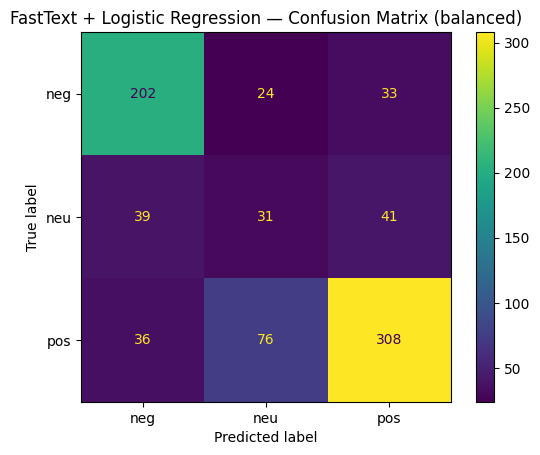

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
from gensim.models.fasttext import load_facebook_vectors

train_file = 'balanced_data_80_balanced.xlsx'
test_file = 'data_with_sentiment_test.xlsx'

train_df = pd.read_excel(train_file)[['Review', 'Sentiment']]
test_df = pd.read_excel(test_file )[['Review', 'Sentiment']]

label_map = { -1:'neg', 0:'neu', 1:'pos',
    'negative':'neg','neutral':'neu','positive':'pos'
}

train_df['Sentiment'] = train_df['Sentiment'].map(label_map)
test_df ['Sentiment'] = test_df ['Sentiment'].map(label_map)

train_df = train_df.dropna(subset=['Sentiment'])
test_df = test_df .dropna(subset=['Sentiment'])

X_train, X_val, y_train, y_val = train_test_split(
    train_df['Review'], train_df['Sentiment'],
    test_size=0.25, random_state=42, stratify=train_df['Sentiment']
)

ft = load_facebook_vectors('cc.ru.300.bin')

def ft_mean(text: str) -> np.ndarray:
    tokens = [tok for tok in text.lower().split() if tok.isalpha()]
    if not tokens:
        return np.zeros(ft.vector_size)
    return np.mean([ft[token] for token in tokens], axis=0)

def embed_series(series):
    return np.vstack([ft_mean(t) for t in tqdm(series, desc='Embedding')])

X_tr_ft = embed_series(X_train)
X_val_ft = embed_series(X_val)
X_te_ft = embed_series(test_df['Review'])

lr = LogisticRegression(class_weight='balanced', C=2, max_iter=400)
lr.fit(X_tr_ft, y_train)

for name, X_, y_ in [
        ('Validation', X_val_ft, y_val),
        ('Test', X_te_ft, test_df['Sentiment'])
]:
    preds = lr.predict(X_)
    print(f'\n--- {name} ---')
    print(classification_report(y_, preds, digits=3))

cm = confusion_matrix(
    test_df['Sentiment'],
    lr.predict(X_te_ft),
    labels=['neg', 'neu', 'pos']
)
ConfusionMatrixDisplay(cm, display_labels=['neg', 'neu', 'pos']).plot(cmap='viridis')
plt.title('FastText + Logistic Regression — Confusion Matrix (balanced)')
plt.show()

/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 790/790 [00:00<00:00, 14703.93 examples/s]
/Users/sabinakalbieva/Documents/add_hse/tools_ad/venv_rubert_sentiment_clean/lib/python3.9/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down

{'eval_f1_macro': 0.7355228893778966, 'eval_loss': 0.6783074736595154, 'eval_runtime': 96.7936, 'eval_samples_per_second': 12.935, 'eval_steps_per_second': 1.622, 'epoch': 0.64}


 18%|█▊        | 500/2820 [31:52<2:41:52,  4.19s/it] 

{'loss': 0.7617, 'grad_norm': 37.12883377075195, 'learning_rate': 1.645390070921986e-05, 'epoch': 1.06}


                                                    
 21%|██▏       | 600/2820 [39:23<1:56:49,  3.16s/it]

{'eval_f1_macro': 0.7150699086182958, 'eval_loss': 0.7145461440086365, 'eval_runtime': 94.8599, 'eval_samples_per_second': 13.198, 'eval_steps_per_second': 1.655, 'epoch': 1.28}


                                                     
 32%|███▏      | 900/2820 [56:18<2:17:51,  4.31s/it]

{'eval_f1_macro': 0.7644887588998094, 'eval_loss': 0.7628837823867798, 'eval_runtime': 89.9442, 'eval_samples_per_second': 13.92, 'eval_steps_per_second': 1.746, 'epoch': 1.91}


 35%|███▌      | 1000/2820 [1:01:28<1:29:05,  2.94s/it]

{'loss': 0.4672, 'grad_norm': 1.757419466972351, 'learning_rate': 1.2907801418439719e-05, 'epoch': 2.13}


                                                       
 43%|████▎     | 1200/2820 [1:14:17<1:28:08,  3.26s/it]

{'eval_f1_macro': 0.807924383873063, 'eval_loss': 0.830062747001648, 'eval_runtime': 95.7464, 'eval_samples_per_second': 13.076, 'eval_steps_per_second': 1.64, 'epoch': 2.55}


 53%|█████▎    | 1500/2820 [1:32:45<1:20:10,  3.64s/it] 

{'loss': 0.2735, 'grad_norm': 0.11366517096757889, 'learning_rate': 9.361702127659576e-06, 'epoch': 3.19}


                                                       
 53%|█████▎    | 1500/2820 [1:34:29<1:20:10,  3.64s/it]

{'eval_f1_macro': 0.8274526403915784, 'eval_loss': 0.8633752465248108, 'eval_runtime': 103.6467, 'eval_samples_per_second': 12.079, 'eval_steps_per_second': 1.515, 'epoch': 3.19}


                                                        
 64%|██████▍   | 1800/2820 [1:53:58<55:14,  3.25s/it]

{'eval_f1_macro': 0.8317454409654029, 'eval_loss': 0.9209029078483582, 'eval_runtime': 89.4626, 'eval_samples_per_second': 13.995, 'eval_steps_per_second': 1.755, 'epoch': 3.83}


 71%|███████   | 2000/2820 [2:05:49<58:52,  4.31s/it]  

{'loss': 0.144, 'grad_norm': 0.13585174083709717, 'learning_rate': 5.815602836879432e-06, 'epoch': 4.26}


                                                       
 74%|███████▍  | 2100/2820 [2:12:57<35:23,  2.95s/it]

{'eval_f1_macro': 0.829120116448296, 'eval_loss': 0.9822309613227844, 'eval_runtime': 94.4004, 'eval_samples_per_second': 13.263, 'eval_steps_per_second': 1.663, 'epoch': 4.47}


                                                       
 85%|████████▌ | 2400/2820 [2:31:04<27:34,  3.94s/it]

{'eval_f1_macro': 0.8442717759087491, 'eval_loss': 0.974702775478363, 'eval_runtime': 94.209, 'eval_samples_per_second': 13.29, 'eval_steps_per_second': 1.667, 'epoch': 5.11}


 89%|████████▊ | 2500/2820 [2:36:51<15:27,  2.90s/it]  

{'loss': 0.0648, 'grad_norm': 0.030290627852082253, 'learning_rate': 2.269503546099291e-06, 'epoch': 5.32}


                                                     
 96%|█████████▌| 2700/2820 [2:50:23<06:29,  3.24s/it]

{'eval_f1_macro': 0.8512087352766923, 'eval_loss': 0.9381608366966248, 'eval_runtime': 96.0096, 'eval_samples_per_second': 13.04, 'eval_steps_per_second': 1.635, 'epoch': 5.74}


100%|██████████| 2820/2820 [2:57:00<00:00,  3.77s/it]  


{'train_runtime': 10620.8459, 'train_samples_per_second': 2.121, 'train_steps_per_second': 0.266, 'train_loss': 0.3073850574222862, 'epoch': 6.0}


100%|██████████| 157/157 [01:41<00:00,  1.55it/s]



--- Validation ---
              precision    recall  f1-score   support

    negative      0.924     0.844     0.882       417
     neutral      0.835     0.825     0.830       417
    positive      0.804     0.883     0.842       418

    accuracy                          0.851      1252
   macro avg      0.854     0.851     0.851      1252
weighted avg      0.854     0.851     0.851      1252



100%|██████████| 99/99 [01:23<00:00,  1.19it/s]



*** Test macro-F1: 0.675


100%|██████████| 99/99 [01:22<00:00,  1.19it/s]



--- Test ---
              precision    recall  f1-score   support

    negative      0.818     0.780     0.798       259
     neutral      0.424     0.351     0.384       111
    positive      0.814     0.874     0.843       420

    accuracy                          0.770       790
   macro avg      0.685     0.668     0.675       790
weighted avg      0.760     0.770     0.764       790



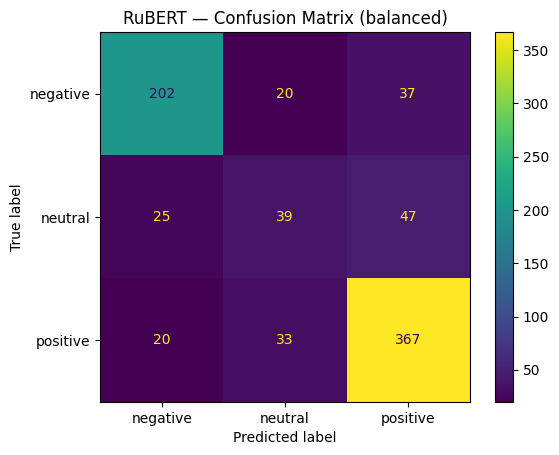

In [3]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)

TRAIN_FILE = 'balanced_data_80_balanced.xlsx'
TEST_FILE  = 'data_with_sentiment_test.xlsx'

df_train = pd.read_excel(TRAIN_FILE)[['Review','Sentiment']].dropna()
df_test  = pd.read_excel(TEST_FILE )[ ['Review','Sentiment']].dropna()

num2str = {-1: "negative", 0: "neutral", 1: "positive"}
df_test['Sentiment'] = df_test['Sentiment'].map(num2str)

le = LabelEncoder().fit(df_train['Sentiment'])
df_train['label'] = le.transform(df_train['Sentiment'])
df_test ['label'] = le.transform(df_test ['Sentiment'])
target_names = [str(c) for c in le.classes_]

from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(
    df_train['Review'], df_train['label'],
    test_size=0.25, stratify=df_train['label'], random_state=42
)

MODEL_NAME = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch['text'], truncation=True, max_length=256)

ds_tr = Dataset.from_dict({'text': X_tr.tolist(), 'labels': y_tr.tolist()}).map(tokenize, batched=True)
ds_val = Dataset.from_dict({'text': X_val.tolist(), 'labels': y_val.tolist()}).map(tokenize, batched=True)
ds_test = Dataset.from_dict({'text': df_test['Review'].tolist(), 'labels': df_test['label'].tolist()}).map(tokenize, batched=True)

class_weights = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
class_w = torch.tensor(class_weights, dtype=torch.float)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=len(target_names))

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels  = inputs.pop("labels")
        outputs = model(**inputs)
        loss = torch.nn.functional.cross_entropy(
            outputs.logits, labels,
            weight=class_w.to(outputs.logits.device)
        )
        return (loss, outputs) if return_outputs else loss

def compute_metrics(p):
    preds  = np.argmax(p.predictions, axis=1)
    report = classification_report(p.label_ids, preds, output_dict=True)
    return {"eval_f1_macro": report['macro avg']['f1-score']}

args = TrainingArguments(
    output_dir='bert_out', 
    num_train_epochs=6, 
    learning_rate=2e-5,
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8,
    evaluation_strategy='steps', 
    eval_steps=300, save_steps=300,
    load_best_model_at_end=True, 
    metric_for_best_model='eval_f1_macro',
    greater_is_better=True, 
    save_total_limit=2, 
    report_to=None, 
    no_cuda=True
)

trainer = WeightedTrainer(
    model=model, args=args,
    train_dataset=ds_tr, eval_dataset=ds_val,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

trainer.train()

val_out = trainer.predict(ds_val)
val_preds = val_out.predictions.argmax(-1)
val_labels= val_out.label_ids
print("\n--- Validation ---")
print(classification_report(val_labels, val_preds, target_names=target_names, digits=3))

trainer.save_model('rubert_sentiment')
tokenizer.save_pretrained('rubert_sentiment')

metrics = trainer.evaluate(ds_test)
print(f"\n*** Test macro-F1: {metrics['eval_f1_macro']:.3f}")
test_preds = trainer.predict(ds_test).predictions.argmax(-1)
print("\n--- Test ---")
print(classification_report(df_test['label'], test_preds, target_names=target_names, digits=3))

cm = confusion_matrix(df_test['label'], test_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=target_names)
disp.plot(cmap='viridis')
plt.title("RuBERT — Confusion Matrix (balanced)")
plt.show()